# Microtask6
>Perform any other analysis you may find interesting, based on the Perceval data you collected.

## Perceval
Perceval is used to retreive the data - [link](https://chaoss.github.io/grimoirelab-tutorial/perceval/intro.html) to tutorial.
>[Perceval](https://github.com/chaoss/grimoirelab-perceval) is a Python module for retrieving data from repositories related to software development. It works with many data sources, from git repositories and GitHub projects to mailing lists, Gerrit or StackOverflow.

## Using Perceval
We will use Perceval **Git backend** for git repositories to retrieve data about commits, and **GitHub backend** to retrieve data about issues and pull requests using the [Github API](https://developer.github.com/).

Perceval can be used:
- As a python module - [git-module documentation](https://perceval.readthedocs.io/en/latest/perceval.backends.core.html#module-perceval.backends.core.git) and [github-module documentation](https://perceval.readthedocs.io/en/latest/perceval.backends.core.html#module-perceval.backends.core.github).
- As a program from commandline 

Github access token is required for authenticated access to the Github API to extend the Api request rate limit.
[Generating the access token](https://help.github.com/en/articles/creating-a-personal-access-token-for-the-command-line)

## Repository details
(The analysis can be done for single or multiple repos(as in microtask #3, #4 and #5).<br>
In this notebook, analysis is done for [mwaskom/seaborn](https://github.com/mwaskom/seaborn) repository, [issue_omnibus](https://github.com/mwaskom/seaborn/tree/issue_omnibus) branch (for commits). The repo is having 772 commits, 1248 issues (including pull_requests, open + closed) and 476 pull_requests.

In [3]:
#from access_token import ACCESS_TOKEN

In [1]:
url = "https://github.com/mwaskom/seaborn"
branch = "issue_omnibus"
owner = url.split('/')[3]
repo = url.split('/')[4]
commit_file = repo + "_commits.json"
issue_file = repo + "_issue.json"
pr_file = repo + "_pr.json"

### Using from commandline - Retrieving data for the Seaborn repository, storing as json.
(Removed the output from here after getting the .json and converted the cell to markdown so the notebook doesn't look cluttered)

In [2]:
#!perceval git $url --json-line --branches $branch > $commit_file
#!perceval github -t $ACCESS_TOKEN --json-line --sleep-for-rate --category issue $owner $repo >> $issue_file
#!perceval github -t $ACCESS_TOKEN --json-line --sleep-for-rate --category pull_request $owner $repo >> $pr_file

### Importing required dependencies

In [3]:
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from requests.exceptions import HTTPError
from pprint import pprint

## 1) Class analyse_commit


In [4]:
class analyse_commit:
    '''
    For each src code file, this shows the total number of commits associated with it.
    For each src code file, it can also show the all the commit id's associated with it if required.
    
    (Here, all the files in the repo are considered part of src code, but this can be modified as required
     based on the definition of src code).
    
    '''
    
    @staticmethod
    def summarize(data):        
        '''
        Returns commit summary containing the required fields
        '''
        
        summary = {
            'commit':data['commit'],
            'commit_message':data['message'],
        }
        modified = []
        for file in data['files']:
            modified.append(file['file'])
        summary['files_modified'] = modified
        return summary
    
    def __init__(self, path):
        '''initializes dataframe with one row per commit'''
        
        self.df = pd.DataFrame(columns = ['commit', 'commit_message', 'files_modified'])
        commits = []
        self.file_df = pd.DataFrame()
        with open(path) as f:
            for line in f:
                line = json.loads(line)
                commits.append(self.summarize(data = line['data']))
        
        self.df = self.df.append(commits, sort = False)
    
    def splitListToRows(self, row , row_accumulator, target_column):
        '''
        Splits a single row of a DataFrame into multiple rows.
        For each entry in the target_column, a new row is made, with entries in all other columns duplicated. 
        '''
        for s in row[target_column]:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
     
        
    def splitDataFrame(self, df, target_col):
        '''
        df = dataframe to split,
        target_col = the column containing the values to split
        returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
        The values in the other columns are duplicated across the newly divided rows.
        '''
        new_rows = []
        df.apply(self.splitListToRows,axis=1,args = (new_rows,target_col))
        new_df = pd.DataFrame(new_rows)
        return new_df
    
    
    def commit_count_file(self):
        '''For each file in the repo,
           returns the number of commits that affected it'''
        
        self.file_df = self.splitDataFrame(self.df, 'files_modified')
        self.file_df.rename(index = str, columns = {'files_modified':'file_name'}, inplace = True)
        a = self.file_df['commit'].groupby(self.file_df['file_name']).agg('count').sort_values(ascending = False)    
        return a.reset_index().rename(index = str, columns = {'commit':'#commits'})
             
           

### Getting the commit_message and the corresponding files modified
This can be used to analyse the relevance of the commit messages to some extent (thinks like whether the commit message describes the changes made in a systematic manner).


In [5]:
analyse1 = analyse_commit("./"+ commit_file)
analyse1.df.head()

,commit,commit_message,files_modified
0,36dd99374a1d6857af7652a9fb832a712a066e16,Initial commit,"[.gitignore, README.rst, seaborn/__init__.py, ..."
1,31eda8fc053ff3aacc20e7c01570efac01c35db1,Small updates,[seaborn/rcmod.py]
2,9caebbff04919e8db78baf544d825190d3fc49d8,More updates to grid parameters,[seaborn/rcmod.py]
3,f39de6924a5ae1d77c013177f177ac9f48e9a72f,Addition of nogrid style,[seaborn/rcmod.py]
4,22d9c3b4e73adc2f9699a4e00141373f695b8e2e,Added color palette options and setting func,[seaborn/rcmod.py]


### For each src code file, getting coumt of all the commits that had any affect on it 
(Here, all the files in the repo are considered part of src code, but this can be modified as required
     based on the definition of src code) <br>
The commit hashes can also be obtained for each src coded file.

In [6]:
analyse1.commit_count_file()

,file_name,#commits
0,seaborn/distributions.py,223
1,seaborn/axisgrid.py,215
2,seaborn/categorical.py,211
3,seaborn/linearmodels.py,199
4,seaborn/matrix.py,184
5,seaborn/plotobjs.py,163
6,seaborn/rcmod.py,139
7,seaborn/tests/test_axisgrid.py,129
8,seaborn/utils.py,124
9,seaborn/basic.py,112


## 2) Class issue_age

In [7]:
class issue_age:
    '''
    Class to calculate the age of all open issues, and plot it as histogram.
    '''
    
    def __init__(self, path):        
        '''
        Initializes the class, for each open issue, open issue age is calculated and stored in a list
        '''
        
        self.issue_age = []
        with open(path) as f:
            for line in f:
                line = json.loads(line)
                ## If the category is issue and it is not a pull request
                if(line['data']['state'] == 'open' and "pull_request" not in line["data"]):
                    self.issue_age.append(self.cal_age(line['data']['created_at']))
            
    def cal_age(self, created):
        '''
        Params - created : time of issue creation        
        Returns age of open issue
        '''
        created = datetime.strptime(created,"%Y-%m-%dT%H:%M:%SZ")
        return(datetime.now() - created).days
           
    
    def plot_age(self):
        '''
        Function to plot the open issue age (histogram).
        '''
        y, x, _ = plt.hist(self.issue_age, bins = int(50),
                             color = 'blue', edgecolor = 'black')

        plt.title("Open Issue Age")
        plt.xlabel("Time(in days)")
        plt.ylabel("Issue Count")
        plt.ylim(top = y.max() + 1)
        plt.show()
        

### Ploting the age of open issues

In [8]:
issue_age1 = issue_age("./"+issue_file)    

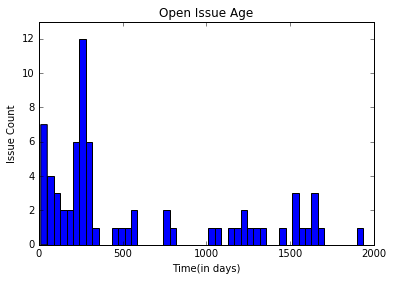

In [9]:
issue_age1.plot_age()

## 3) Class pr_first_response

In [13]:
class pr_first_response:
    '''
    Class to calculate the time required for first response to a pull request after it is made.
    Review as well as comment, both are considered as response.
    '''
    @staticmethod
    def get_date(url, candidate):
        try:
            response = requests.get(url, headers={'Authorization': 'Bearer {}'.format('3f7210425d61134182aa5c606079d1c63c651cee')})
            if(response.ok):
                content = json.loads(response.text)                
                # check if reponse contains an empty list (no comments (or reviews) present)
                if not content:
                    return None
                
                # if getting the date for first comment
                if (candidate == "comments"):
                    date = datetime.strptime(content[0]["created_at"], "%Y-%m-%dT%H:%M:%SZ")
                    return date
                
                # if getting the date for first review (candidate == review)
                else :
                    date = datetime.strptime(content[0]["submitted_at"], "%Y-%m-%dT%H:%M:%SZ")
                    return date
                
            else:
                response.raise_for_status()                         
                            
        except HTTPError as http_err:
            print('HTTP error occurred:', {http_err})
        except Exception as err:
            print('Other error occurred:', {err}) 
        
    def summarize(self, data):
        '''
        Returns the required pull_request summary
        '''
        created_at = datetime.strptime(data['created_at'], "%Y-%m-%dT%H:%M:%SZ")
        #summary = {'created_at' : created_at}
        summary = dict()
        comment_url = data['_links']['comments']['href']
        review_url = "https://api.github.com/repos/" + owner + "/" + repo + "/pulls/" + str(data['number']) + "/reviews"
        comment_date = self.get_date(comment_url, candidate = "comments")
        review_date = self.get_date(review_url, candidate = "reviews")
        
        # if both comment and review exists        
        if (comment_date and review_date):
            first_date = min(comment_date, review_date)
            summary = {'first_response_at':first_date,
                       'first_response_duration':first_date - created_at
                      }
            
            if(first_date is comment_date):
                summary['first_response_type'] = "comment"
            else:
                summary['first_response_type'] = "review"            
        
        # if comment_date is None (i.e no comment exists)
        elif (not(comment_date) and review_date):
            summary = {'first_response_at':review_date,
                      'first_response_type':"review",
                       'first_response_duration':review_date - created_at
                      }
        
        # if review_date is None (i.e no review exists)
        elif (not(review_date) and comment_date):
            summary = {'first_response_at':comment_date,
                      'first_response_type':"comment",
                       'first_response_duration':comment_date - created_at
                      }        
        
        summary['created_at'] = created_at
        return summary
    
       
    def __init__(self, path):
        '''
        Initializes the class,
        a dataframe containing the first response duration is made for each pull_request.
        '''
        
        self.df = pd.DataFrame(columns = ['created_at', 'first_response_at', 'first_response_type', 'first_response_duration'])
        content = []
        with open(path) as f:
            for line in f:
                line = json.loads(line)
                #pprint(line['data'])
                #break
                content.append(self.summarize(data = line['data']))
        self.df = self.df.append(content, sort = False)  
                
        
        

### Getting the time after which first response was made on the PR
The fields present in the DataFrame:
- 'created_at' : "When the PR was created"
- 'first_response_type' : "comment"/"review"
- 'first_respone_at' : "Time of first response to the PR"
- 'first_response_duration' : "Time elapsed after the PR was opened till the first response on it"

**The rows having the value 'Nat' means no response was made to those PR's**, they were directly merged, closed or are still open.<br>
(We can remove these rows from here since we are particularly interested in the analysis of **PR_first_response**)

In [17]:
first_response = pr_first_response("./" + pr_file)

In [18]:
first_response.df.head(20)

,created_at,first_response_at,first_response_type,first_response_duration
0,2013-09-09 23:23:34,NaT,NaN,NaT
1,2013-09-09 23:27:31,NaT,NaN,NaT
2,2013-11-21 03:46:50,NaT,NaN,NaT
3,2013-11-26 17:47:06,NaT,NaN,NaT
4,2013-12-10 04:31:00,NaT,NaN,NaT
5,2013-12-10 15:05:40,2013-12-10 15:49:21,comment,0 days 00:43:41
6,2013-12-06 17:56:31,2013-12-06 19:03:57,comment,0 days 01:07:26
7,2013-12-13 03:37:43,NaT,NaN,NaT
8,2013-12-13 00:57:24,NaT,NaN,NaT
9,2013-12-13 10:28:26,2013-12-13 17:32:38,comment,0 days 07:04:12
